* By: Illya Barziy
* Email: illyabarziy@gmail.com
* Reference: Advances in Financial Machine Learning, Chapter-14

## Chapter 14 Backtest Statistics

## Introduction

Whenever a strategy is created, it's performance has to be tested and reported. This chapter covers some of the statistics that are used for understanding the charachteristics of a strategy related to levels of risk and return. It also provides tools to test if the strategy satisfies desired profitability benchmarks (Sharpe ratio in particular). Statistics in this chapter cover the following topics:
- Drawdown
- Time under water
- Herfindahl-Hirschman Index or Concentration of returns
- Sharpe ratio
- Probabalistic Sharpe ratio
- Deflated Sharpe ratio

In this notebook the exercises from Chapter-14 in the book "Advances in Financial Machine Learning" are implemented. 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from random import gauss
from itertools import product
import matplotlib.pyplot as plt
#import mlfinlab


In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'C:/Users/Illya/Projects/ml/mlfinlab')

In [3]:
import warnings
warnings.filterwarnings('ignore')
from mlfinlab import backtest_statistics as bs

## Question-14.1

### A strategy exhibits a high turnover, high leverage, and high number of bets, with a short holding period, low return on execution costs, and a high Sharpe ratio. Is it likely to have large capacity? What kind of strategy do you think it is?

Looking closer to the characteristics:
- High turnover means that measures the ratio of the average amount traded per year is higher than the average annual assets under management (AUM). It can occur either when either positions are often tuned or flipped.
- High leverage means that the amounts borrowed for strategy execution are high compared to AUM.
- High number for bets occurs when positions are changed frequently. That shows that the strategy certainly doesn't have long holding periods.
- Short holding periods go in line with the previous characteristic.
- low return on execution cases - when the ratio between dollar performance (including brokerage fees and slippage costs) and total execution costs is low, there are high chances that strategy won't survive worse-than-expected execution.
- High Sharpe ratio shows that returns are high and have a relatively low level of volatility

Capacity is defined as the highest AUM that delivers a target risk-adjusted performance. Since the strategy shows high leverage, it isn't likely to have high capacity since a big portion of resources is borrowed.

This results into assuming that this is a High-frequency trading strategy (HFT), that frequently changes it's positions and uses big amounts of borrowed resources so that effects from small changes in price are significant. Shore holding periods fit the description, as well as low return on execution costs, as slippage or delays in execution may vanish the profits. High Sharpe ratio shows that it's successful.

## Question-14.2

### On the dollar bars dataset for E-mini S&P 500 futures, compute
### (a) HHI index on positive returns

In [4]:
# Read in data
data = pd.read_csv('../Sample-Data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [5]:
data

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332
...,...,...,...,...,...,...,...
2016-12-30 20:59:58.848,2236.00,2236.50,2235.75,2236.50,31334,70065316.00,1408
2016-12-30 21:00:00.352,2236.25,2237.50,2235.75,2235.75,31456,70355994.75,832
2016-12-30 21:00:24.294,2236.00,2237.00,2235.00,2236.25,31319,70029228.00,1123


In [6]:
#Transforing to returns from a long position
data_series = data['close'].diff()[1:]

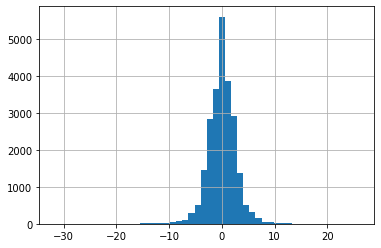

In [7]:
data_series.hist(bins=50)
plt.show()

In [8]:
#Uning mlfinlab package function for derailed concentration output
pos_concentr, neg_concentr, hourly_concentr = bs.all_bets_concentration(data_series, frequency='H')

In [9]:
print('HHI index of positive returns is' , pos_concentr)

HHI index of positive returns is 7.952098928327844e-05


Concentration (or HHI index) on positive returns is fairly close to zero. From it's properties we can concluse that the returns distribution is likely not to have fat right tail. 

### (b) HHI index on negative returns.

In [10]:
print('HHI index of negative returns is' , neg_concentr)

HHI index of negative returns is 7.913393113578027e-05


Concentration (or HHI index) on negative returns is fairly close to zero, same as for positive ones. From it's properties we can concluse that the returns distribution is likely not to have fat left tail. 

### (c) HHI index on time between bars

In [11]:
print('HHI index of returns divided by hourly bins is' , hourly_concentr)

HHI index of returns divided by hourly bins is 0.00018884181203148828


Concentration (or HHI index) on time between bars (from set, roughly 1h between bars) is low. This means bets are not concentrated in time, or are close to uniformly distributed across time.

### (d) The 95-percentile DD

In [12]:
#Getting series of prices
price_series = data['close'][1:]

In [13]:
#Uning mlfinlab package function to get drawdowns and time under water series
drawdown, tuw = bs.drawdown_and_time_under_water(price_series, dollars = False)
drawdown_dollars, _ = bs.drawdown_and_time_under_water(price_series, dollars = True)

In [14]:
print('The 95th percentile of Drawdown is' , drawdown.quantile(.95))

The 95th percentile of Drawdown is 0.026251287963770763


In [15]:
print('The 95th percentile of Drawdown in dollars is' , drawdown_dollars.quantile(.95))

The 95th percentile of Drawdown in dollars is 56.19999999999995


This means that from the observed set, 95% of drawdowns are below 0.026 or 2,6% of portfolio (If assuming long position). In dollar equivalent it is $56.20.

### (e) The 95-percentile TuW

In [16]:
print('The 95th percentile of Time under water' , tuw.quantile(.95))

The 95th percentile of Time under water 0.04477236987906801


From the results, 95% of time under water is below 0.044 years, or 16,34 days.

### (f) Annualized average return.

In [17]:
# Using simple formula for annual return
days_observed = (price_series.index[-1] - price_series.index[0]) / np.timedelta64(1, 'D')
cumulated_return = price_series[-1]/price_series[0]
annual_return = (cumulated_return)**(365/days_observed) - 1

In [18]:
print('Annualized average return from data is' , annual_return)

Annualized average return from data is 0.04068052208872763


So, average annual return from given data is 4,068%

### (g) Average returns from hits (positive returns).

In [19]:
print('Average returns from positive bars in dollars is' , data_series[data_series>0].mean(), 
      'and counter is', data_series[data_series>0].count())
#Also looking at results grouped by days
returns_by_days = data_series.groupby(pd.Grouper(freq='D')).sum()
returns_by_days = returns_by_days[returns_by_days!=0]
print('Average returns from positive bars grouped by days in dollars is' , 
      returns_by_days[returns_by_days>0].mean(), 'and counter is', 
      returns_by_days[returns_by_days>0].count())

Average returns from positive bars in dollars is 2.024980568270144 and counter is 11579
Average returns from positive bars grouped by days in dollars is 12.571302816901408 and counter is 284


Average returns from bar hits is 2,025 and from day hits 12,571. Hits from bars are 40 times more frequent than day

### (h) Average return from misses (negative returns).

In [20]:
print('Average returns from negative bars in dollars is' , data_series[data_series<0].mean(),
     'and counter is', data_series[data_series<0].count())
print('Average returns from negative bars grouped by days in dollars is' , 
      returns_by_days[returns_by_days<0].mean(), 'and counter is',
      returns_by_days[returns_by_days<0].count())

Average returns from negative bars in dollars is -2.057200954822739 and counter is 11311
Average returns from negative bars grouped by days in dollars is -12.470588235294118 and counter is 272


Average returns from bar misses is -2,057 and from day hits -12,447. The number of misses is just slightly lower than number of hits.

### (i) Annualized SR

In [21]:
#Uning mlfinlab package function to get SR
annualized_sr = bs.sharpe_ratio(returns_by_days, cumulative=False, entries_per_year=days_observed, risk_free_rate=0)
print('Annualized Sharpe Ratio (with risk-free rate assumed to be zero) is' , annualized_sr)

Annualized Sharpe Ratio (with risk-free rate assumed to be zero) is 0.49433639999746987


The annualized Sharpe ratio for the long position on the portfolio is fairly low at 0,4318.

### (j) Information ratio, where the benchmark is the risk-free rate.

Inforamtion ratio is the relation of mean excess return over a benchmark to the standard deviation of that excess return over a benchmark.

For the nenchmark, let's assume the risk-free rate to be the 10 year treasury rate at the beginning of 2020 at 1,8% per year

In [22]:
#Stating the risk-free ratio and trading days per year
risk_free_ratio = 0.018
trading_days = 252
#Getting returns in percentages as return in a day divided by starting price of the day
open_by_days = data['close'].groupby(pd.Grouper(freq='D')).first().dropna()
percentage_returns = returns_by_days / open_by_days[1:]

#Calculating excess returns above the risk-free ratio
excess_returns = percentage_returns - risk_free_ratio / trading_days

#Now, for the calculation of the Inforamtion ratio, a Sharpe ratio function can be used
#with zero risk-free rate parameter.
information_ratio = bs.sharpe_ratio(excess_returns, cumulative=False, 
                                    entries_per_year=days_observed, risk_free_rate=0)
print('Information ratio is' , information_ratio)

Information ratio is 0.3369951835875305


Information ratio is the Sharpe ratio equivalent of a portfolio that measures its performance relative to a benchmark. It is lower than the Sharpe ratio, as expected, as we're measuring a relative performance of a portfolio. It is still positive, which means that portfolio outperforms the benchmark of a risk-free rate.

### (k) PSR.

The probabilistic Sharpe ratio (PSR) provides an adjusted estimate of SR, by removing the inflationary effect caused by short series with skewed and/or fat-tailed returns.

As no benchmark Sharpe ratio is provided, let's assume it to be at 0.48, a bit lower than the previously calculated Annual SR.

In [23]:
#Uning mlfinlab package function to get PSR
probabalistic_sr = bs.probabalistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                 benchmark_sr=0.48, 
                                                 number_of_returns=days_observed, 
                                                 skewness_of_returns=returns_by_days.skew(), 
                                                 kurtosis_of_returns=returns_by_days.kurt())
print('Probabalistic Sharpe Ratio with benchmark SR of 0.48 is' , probabalistic_sr)

Probabalistic Sharpe Ratio with benchmark SR of 0.48 is 0.6348122154832554


As the value is lower than 0.95, we have to reject the hypothesis that Sharpe ratio is 0.49 for the 5% significance level.

In [24]:
probabalistic_sr_adj = bs.probabalistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                     benchmark_sr=0.4259, 
                                                     number_of_returns=days_observed, 
                                                     skewness_of_returns=returns_by_days.skew(), 
                                                     kurtosis_of_returns=returns_by_days.kurt())
print('Probabalistic Sharpe Ratio with benchmark SR of 0.4259 is' , probabalistic_sr_adj)

Probabalistic Sharpe Ratio with benchmark SR of 0.4259 is 0.9500264835705009


Howewer, with the benchmark SR of 0.4259, the PSR is just above 0.95. So, we can assume Sharpe ratio to be 0.4259 for the 5% significance level.

### (l) DSR, where we assume there were 100 trials, and the variance of the trials’ SR was 0.5.

Deflated Sharpe Ratio (DSR) is a PSR where the rejection threshold is adjusted to reflect the multiplicity of trials. DSR is estimated as PSR[SR∗], where the benchmark Sharpe ratio, SR∗, is no longer user-defined, but calculated from SR estimate trails.

Again taking 0.49 as a benchmark Sharpe ratio.

In [25]:
#As the current function accepts only lists of trails, let's generate one and pass it as a parameter.
trails_list = np.random.normal(0.49, 0.5**(1/2), 100)

#Uning mlfinlab package function to get DSR
deflated_sr = bs.deflated_sharpe_ratio(observed_sr=annualized_sr, 
                                       sr_estimates=trails_list, 
                                       number_of_returns=days_observed, 
                                       skewness_of_returns=returns_by_days.skew(), 
                                       kurtosis_of_returns=returns_by_days.kurt())
print('Deflated Sharpe Ratio with benchmark SR of 0.49 is' , deflated_sr)

Deflated Sharpe Ratio with benchmark SR of 0.49 is 1.2234104019953887e-202


Deflated Sharpe ratio is extremely low. This is because the benchmark in the estimate is set high:

In [26]:
benchmark_sr_dsr = np.array(trails_list).std() * \
                   ((1 - np.euler_gamma) * ss.norm.ppf(1 - 1 / len(trails_list)) +
                    np.euler_gamma * ss.norm.ppf(1 - 1 / len(trails_list) * np.e ** (-1)))

print('Benchmark Sharpe ratio used in DSR is' , benchmark_sr_dsr)

Benchmark Sharpe ratio used in DSR is 1.7569290498169754


If the number of trails was smaller, the results would be different:

In [27]:
trails_list_adj = np.random.normal(0.49, 0.5**(1/2), 4)

benchmark_sr_dsr_adj = np.array(trails_list_adj).std() * \
                       ((1 - np.euler_gamma) * ss.norm.ppf(1 - 1 / len(trails_list_adj)) +
                       np.euler_gamma * ss.norm.ppf(1 - 1 / len(trails_list_adj) * np.e ** (-1)))

print('Deflated Sharpe Ratio with benchmark SR of 0.49 is' , benchmark_sr_dsr_adj)

Deflated Sharpe Ratio with benchmark SR of 0.49 is 0.9815966859130163


## Question-14.3

### Consider a strategy that is long one futures contract on even years, and is short one futures contract on odd years.

### (a) Repeat the calculations from exercise 2.

### (b) What is the correlation to the underlying?

## Question-14.4

### The results from a 2-year backtest are that monthly returns have a mean of 3.6%, and a standard deviation of 0.079%.

### (a) What is the SR?

Simple Sharpe ratio is calculated as:

$SR=\frac{E[r]}{\sqrt{V[r]}}$, where $r$ - monthly returns.

So, $SR = \frac{3.6}{0.079} = 45,57$

It's ho high due to standard deviation is being so low. This means that 99,7% of returns fall in the (3,363%;3,837%). If we use risk-free rate for the calculation, say 1,8%, then:

$SR=\frac{E[r]-R_f}{\sqrt{V[r]}}$, where $r$ - monthly returns, $R_f$ - risk-free rate

So, $SR = \frac{3.6-1.8}{0.079} = 22,78$

This SR is lower, however still high, as standard deviation is the same.

### (b) What is the annualized SR?

Annualized Sharpe ratio is calculated as:

$SR=\frac{E[r]}{\sqrt{V[r]}}*\sqrt{N}$, where $r$ - monthly returns, $N$ - number of obbervations per year.

So, $SR = \frac{3.6}{0.079}*\sqrt{12} = 157,86$


## Question-14.4

### Following on exercise 1:
### (a) The returns have a skewness of 0 and a kurtosis of 3. What is the PSR?

Exercise 1 gives no details on exact Sharpe ratio or number of observed returns, so we can't calculate the exact PSR.

From a theoretical perspective, PSR corrects SR for inflationary effects caused by non-Normal returns. Skewness of 0 and kurtosis of 3 show that returns are normal. The changes of skewness, kurtosis and number of observations change PSR in a the following way:

In [28]:
#From the example with nymbers in Exercise 2:
probabalistic_sr = bs.probabalistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                 benchmark_sr=0.48, 
                                                 number_of_returns=days_observed, 
                                                 skewness_of_returns=-2.4, 
                                                 kurtosis_of_returns=10.1)
print('Probabalistic Sharpe Ratio with benchmark SR of 0.48 is' , probabalistic_sr)


Probabalistic Sharpe Ratio with benchmark SR of 0.48 is 0.5923206649935808


However, if we massively increase the numbr of returns observed, leaving other parameters intact:

In [29]:
probabalistic_sr = bs.probabalistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                 benchmark_sr=0.48, 
                                                 number_of_returns=days_observed + 10000, 
                                                 skewness_of_returns=-2.4, 
                                                 kurtosis_of_returns=10.1)
print('Probabalistic Sharpe Ratio with benchmark SR of 0.48 and', 
      'high number of obxervations is' , probabalistic_sr)

Probabalistic Sharpe Ratio with benchmark SR of 0.48 and high number of obxervations is 0.8150510539014713


As seen, with an increase of observations, PSR rises.

### (b) The returns have a skewness of -2.448 and a kurtosis of 10.164. What is the PSR?

Both lower values of skewness (heavy right tail) and higher values of kurtosis (heavy tails) decrease the PSR. WE can see this from the example:

In [30]:
probabalistic_sr = bs.probabalistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                 benchmark_sr=0.48, 
                                                 number_of_returns=days_observed, 
                                                 skewness_of_returns=0, 
                                                 kurtosis_of_returns=3)
print('Probabalistic Sharpe Ratio with benchmark SR of 0.48 and', 
      'normal returns is' , probabalistic_sr)

Probabalistic Sharpe Ratio with benchmark SR of 0.48 and normal returns is 0.6424624182675767


In [31]:
probabalistic_sr = bs.probabalistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                 benchmark_sr=0.48, 
                                                 number_of_returns=days_observed, 
                                                 skewness_of_returns=-2.4, 
                                                 kurtosis_of_returns=10.1)
print('Probabalistic Sharpe Ratio with benchmark SR of 0.48 and', 
      'negatively-skewed, leptokurtic returns is' , probabalistic_sr)

Probabalistic Sharpe Ratio with benchmark SR of 0.48 and negatively-skewed, leptokurtic returns is 0.5923206649935808


## Question-14.6

### What would be the PSR from 2.b, if the backtest had been for a length of 3 years?

## Question-14.7

### A 5-year backtest has an annualized SR of 2.5, computed on daily returns. The skewness is -3 and the kurtosis is 10.

### (a) What is the PSR?

Using the PSR formula:

$PSR[SR*] = Z[\frac{(SR - SR*)\sqrt{T-1}}{\sqrt{1-\gamma_3SR+\frac{\gamma_4-1}{4}SR^2}}]$

With SR 2.2 as a benchmark, 

$PSR[2.2] = Z[\frac{(2.5-2.2)\sqrt{1260-1}}{\sqrt{1-(-3)*2.5+\frac{10-1}{4}2.5^2}}] = 0.9875 $

So, at 5% significance level, Sharpe ratio is higher than the benchmark 2.2 SR. 


In [32]:
probabalistic_sr = bs.probabalistic_sharpe_ratio(observed_sr=2.5, 
                                                 benchmark_sr=2.2, 
                                                 number_of_returns=1260, 
                                                 skewness_of_returns=-3, 
                                                 kurtosis_of_returns=10)
print('Probabalistic Sharpe Ratio is' , probabalistic_sr)

Probabalistic Sharpe Ratio is 0.9874867374822187


### (b) In order to find that best result, 100 trials were conducted. The variance of the Sharpe ratios on those trials is 0.5. What is the DSR?

Using the DSR formula:

$SR* = \sqrt{V[SR_n]}((1-\gamma)*Z^{-1}[1-\frac{1}{N}]+\gamma*Z^{-1}[1-\frac{1}{N}e^{-1}])$

$SR* = \sqrt{0.5}((1-\gamma)*Z^{-1}[1-\frac{1}{100}]+\gamma*Z^{-1}[1-\frac{1}{100}e^{-1}]) = 1.7894$ 

And:

$DSR[SR*] = Z[\frac{(SR - SR*)\sqrt{T-1}}{\sqrt{1-\gamma_3SR+\frac{\gamma_4-1}{4}SR^2}}]$

$DSR[1.7894] = Z[\frac{(2.5-1.7894)\sqrt{1260-1}}{\sqrt{1-(-3)*2.5+\frac{10-1}{4}2.5^2}}] = 0.99 $

So, for the 5% significance level, SR is higher than the benchmark 1.7894. Therefore it omits multiple testing/selection  bias.

In [33]:
benchmark_sr_dsr = (0.5)**(1/2) * \
                   ((1 - np.euler_gamma) * ss.norm.ppf(1 - 1 / 100) +
                   np.euler_gamma * ss.norm.ppf(1 - 1 / 100 * np.e ** (-1)))

print('Calculated benchmark Sharpe ratio is', benchmark_sr_dsr)

deflated_sr = bs.probabalistic_sharpe_ratio(observed_sr=2.5, 
                                            benchmark_sr=benchmark_sr_dsr, 
                                            number_of_returns=1260, 
                                            skewness_of_returns=-3, 
                                            kurtosis_of_returns=10)

print('Deflated Sharpe ratio is', deflated_sr)

Calculated benchmark Sharpe ratio is 1.7894064662732079
Deflated Sharpe ratio is 0.9999999446183043


## Conclusion

Chapter provides formula solutions for:
 * Estimation of average holding period;
 * Calculation of Drawdown;
 * Calculation of Time under Water;
 * Herfindahl-Hirschman Index or Concentration of returns;
 * Sharpe ratio;
 * Information ratio;
 * Probabalistic Sharpe ratio;
 * Deflated Sharpe ratio;

Key takewaysfrom the chapter:

 * HHI index on dollar bars returns shows that both right and left tails of returns are close to normal. Dollar bars divided by hourly bins show that time concentration of returns is low, which means returns are close to uniform distribution actoss time.
 
 * From the provided Drawdown and Time under water function, quantiles can be easily calculatied in order to estimate expected drawdowns and times under water with 95% certainty.
 
 * Information fario is a good alternative to the Sharpe ratio, when taking into account available risk-free rate.
 
 * The probabilistic Sharpe ratio (PSR) provides an adjusted estimate of SR, by removing the inflationary effect caused by short series with skewed and/or fat-tailed returns.
 
 * All else equal:
   * Increase in number of observations increases PSR
   * Decrease in skewness of returns decreases PSR
   * Increase in kurtosis of returns decreases PSR
 
 
 * Deflated Sharpe Ratio (DSR) is a PSR where the rejection threshold is adjusted to reflect the multiplicity of trials. DSR is estimated as PSR[SR∗], where the benchmark Sharpe ratio, SR∗, is no longer user-defined, but calculated from SR estimate trails.

Papers used in the chapter:

* David H. Bailey and Marcos Lopez de Prado (2011): "The Sharpe Ratio Efficient Frontier." Journal of Risk, Vol. 15, No. 2, Winter 2012/13. Available at https://papers.ssrn.com/abstract_id=1821643. (Provides a deeper understanding of Sharpe ratios implemented and Minimum track record length - required numner of trails to conclude that the SR is above the benchmark)